#### Brain Tumor Detection using base model ResNet50V2  With Accuracy~98%

#### Data Uploading

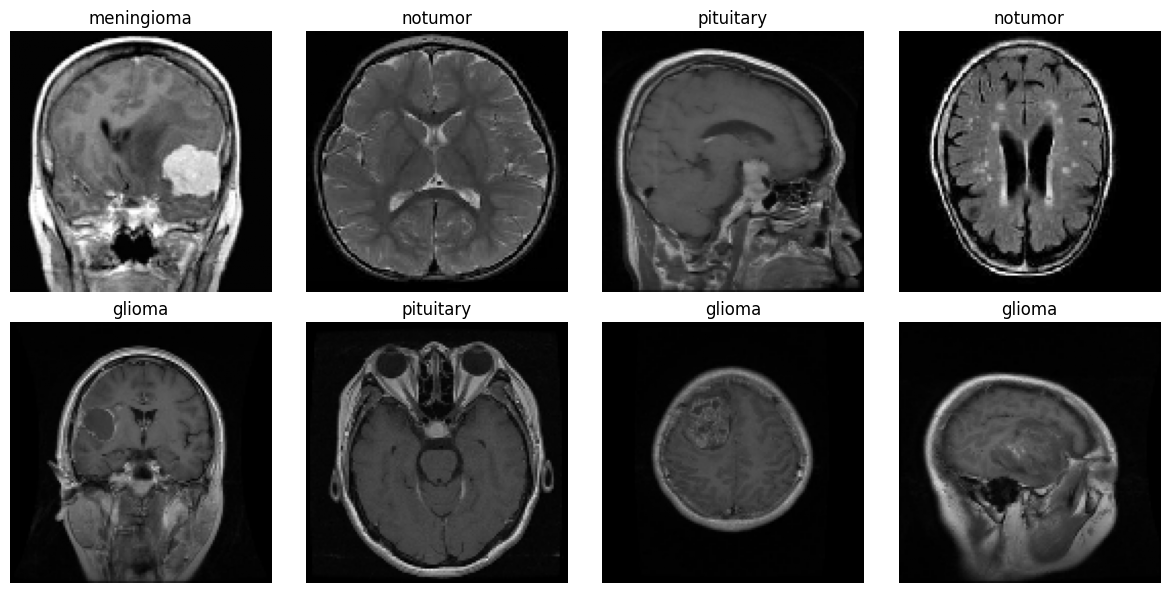

In [1]:
import os
import numpy as np
import random
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance


test_dir = "C:/MIT/brain_tumor_detection dataset/Testing/"
train_dir = "C:/MIT/brain_tumor_detection dataset/Training/"

# Collecting image paths and labels
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            train_paths.append(image_path)
            train_labels.append(label)

# Shuffling the data
train_paths, train_labels = shuffle(train_paths, train_labels)

IMAGE_SIZE = 128

def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths):
    images = [augment_image(load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))) for path in paths]
    return np.array(images)

images = open_images(train_paths[:10])
labels = train_labels[:10]

plt.figure(figsize=(12, 6))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

In [2]:
unique_labels=os.listdir(train_dir)

def encode_label(labels):
    encoded=[]
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(label):
    return unique_labels[label]

def data_generator(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

#### Model Building,Deployment

In [3]:
from tensorflow import keras
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy



IMAGE_SIZE = 128
NUM_CLASSES = len(unique_labels)  # You need to define `unique_labels` before using this

# Loading the ResNet50V2 model with pre-trained weights
base_model = ResNet50V2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Setting all layers in the base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Setting the last few layers in the base model to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Creating a sequential model
model = Sequential([
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    base_model,
    Flatten(),
    Dropout(0.5),  
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),   
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# Using the Adam optimizer with a lower learning rate
# Lower learning rate for fine-tuning
optimizer = Adam(lr=0.0001) 
# Compiling the model with Adam optimizer and custom learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])
#summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [4]:
batch_size = 20
steps_per_epoch = int(len(train_paths) / batch_size)
epochs = 6

# Training the model using the data generator
history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps_per_epoch)


Epoch 1/6
285/285 [==============================] - 288s 931ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.7525
Epoch 2/6
285/285 [==============================] - 2575s 9s/step - loss: 0.7705 - sparse_categorical_accuracy: 0.8895
Epoch 3/6
285/285 [==============================] - 164s 573ms/step - loss: 0.6568 - sparse_categorical_accuracy: 0.9253
Epoch 4/6
285/285 [==============================] - 139s 487ms/step - loss: 0.5635 - sparse_categorical_accuracy: 0.9545
Epoch 5/6
285/285 [==============================] - 225s 789ms/step - loss: 0.5196 - sparse_categorical_accuracy: 0.9689
Epoch 6/6
285/285 [==============================] - 186s 648ms/step - loss: 0.4991 - sparse_categorical_accuracy: 0.9714


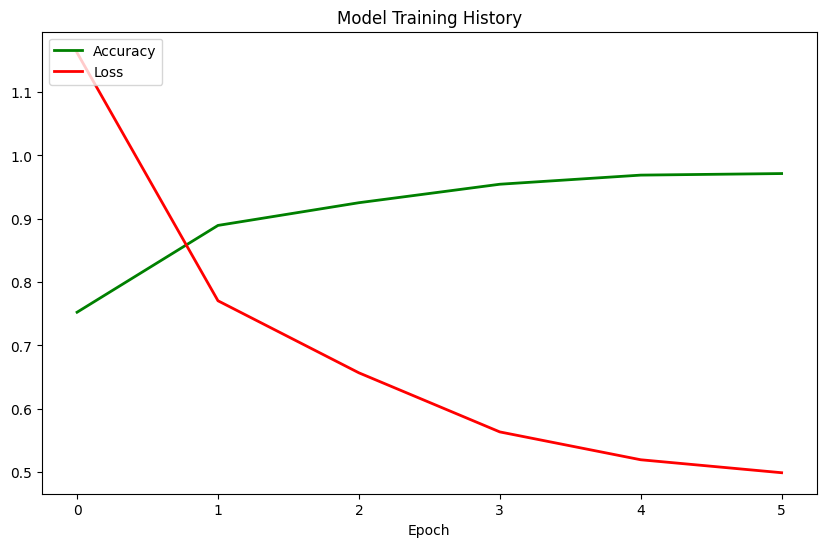

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], 'g-', linewidth=2, label='Accuracy')  # Changed color and label
plt.plot(history.history['loss'], 'r-', linewidth=2, label='Loss')  # Changed color and label
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.xticks(range(epochs))  # Use `range` directly
plt.legend(loc='upper left')
plt.show()

 

#### Evaluating the Model

In [6]:
from tqdm import tqdm
batch_size = 32
steps = int(len(test_paths) / batch_size)
y_pred = []
y_true = []

for x, y in tqdm(data_generator(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    
    y_pred.extend(pred)  # Extend the predicted labels list
    y_true.extend(y)     # Extend the true labels list

# Convert the predicted and true labels to human-readable labels
y_pred_labels = [decode_label(label) for label in y_pred]
y_true_labels = [decode_label(label) for label in y_true]


  0%|          | 0/40 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  2%|▎         | 1/40 [00:01<01:02,  1.60s/it]

1/1 [==============================] - 1s 589ms/step


  5%|▌         | 2/40 [00:02<00:40,  1.07s/it]

1/1 [==============================] - 1s 566ms/step


  8%|▊         | 3/40 [00:02<00:32,  1.13it/s]

1/1 [==============================] - 1s 566ms/step


 10%|█         | 4/40 [00:03<00:28,  1.26it/s]

1/1 [==============================] - 1s 580ms/step


 12%|█▎        | 5/40 [00:04<00:26,  1.33it/s]

1/1 [==============================] - 1s 578ms/step


 15%|█▌        | 6/40 [00:04<00:24,  1.38it/s]

1/1 [==============================] - 1s 591ms/step


 18%|█▊        | 7/40 [00:05<00:23,  1.40it/s]

1/1 [==============================] - 1s 561ms/step


 20%|██        | 8/40 [00:06<00:22,  1.43it/s]

1/1 [==============================] - 1s 597ms/step


 22%|██▎       | 9/40 [00:07<00:21,  1.43it/s]

1/1 [==============================] - 1s 601ms/step


 25%|██▌       | 10/40 [00:07<00:20,  1.44it/s]

1/1 [==============================] - 1s 602ms/step


 28%|██▊       | 11/40 [00:08<00:20,  1.43it/s]

1/1 [==============================] - 1s 599ms/step


 30%|███       | 12/40 [00:09<00:19,  1.44it/s]

1/1 [==============================] - 1s 602ms/step


 32%|███▎      | 13/40 [00:09<00:18,  1.43it/s]

1/1 [==============================] - 1s 557ms/step


 35%|███▌      | 14/40 [00:10<00:18,  1.44it/s]

1/1 [==============================] - 1s 583ms/step


 38%|███▊      | 15/40 [00:11<00:17,  1.45it/s]

1/1 [==============================] - 1s 564ms/step


 40%|████      | 16/40 [00:11<00:16,  1.46it/s]

1/1 [==============================] - 1s 586ms/step


 42%|████▎     | 17/40 [00:12<00:15,  1.47it/s]

1/1 [==============================] - 1s 586ms/step


 45%|████▌     | 18/40 [00:13<00:15,  1.47it/s]

1/1 [==============================] - 1s 570ms/step


 48%|████▊     | 19/40 [00:13<00:14,  1.48it/s]

1/1 [==============================] - 1s 562ms/step


 50%|█████     | 20/40 [00:14<00:13,  1.47it/s]

1/1 [==============================] - 1s 584ms/step


 52%|█████▎    | 21/40 [00:15<00:12,  1.47it/s]

1/1 [==============================] - 1s 557ms/step


 55%|█████▌    | 22/40 [00:15<00:12,  1.48it/s]

1/1 [==============================] - 1s 622ms/step


 57%|█████▊    | 23/40 [00:16<00:11,  1.45it/s]

1/1 [==============================] - 1s 669ms/step


 60%|██████    | 24/40 [00:17<00:11,  1.41it/s]

1/1 [==============================] - 1s 668ms/step


 62%|██████▎   | 25/40 [00:18<00:10,  1.37it/s]

1/1 [==============================] - 1s 615ms/step


 65%|██████▌   | 26/40 [00:18<00:10,  1.37it/s]

1/1 [==============================] - 1s 595ms/step


 68%|██████▊   | 27/40 [00:19<00:09,  1.39it/s]

1/1 [==============================] - 1s 653ms/step


 70%|███████   | 28/40 [00:20<00:08,  1.36it/s]

1/1 [==============================] - 1s 605ms/step


 72%|███████▎  | 29/40 [00:21<00:07,  1.38it/s]

1/1 [==============================] - 1s 682ms/step


 75%|███████▌  | 30/40 [00:21<00:07,  1.35it/s]

1/1 [==============================] - 1s 635ms/step


 78%|███████▊  | 31/40 [00:22<00:06,  1.34it/s]

1/1 [==============================] - 1s 604ms/step


 80%|████████  | 32/40 [00:23<00:05,  1.36it/s]

1/1 [==============================] - 1s 618ms/step


 82%|████████▎ | 33/40 [00:24<00:05,  1.37it/s]

1/1 [==============================] - 1s 626ms/step


 85%|████████▌ | 34/40 [00:24<00:04,  1.35it/s]

1/1 [==============================] - 1s 606ms/step


 88%|████████▊ | 35/40 [00:25<00:03,  1.37it/s]

1/1 [==============================] - 1s 604ms/step


 90%|█████████ | 36/40 [00:26<00:02,  1.38it/s]

1/1 [==============================] - 1s 604ms/step


 92%|█████████▎| 37/40 [00:26<00:02,  1.39it/s]

1/1 [==============================] - 1s 666ms/step


 95%|█████████▌| 38/40 [00:27<00:01,  1.35it/s]

1/1 [==============================] - 1s 587ms/step


 98%|█████████▊| 39/40 [00:28<00:00,  1.37it/s]

1/1 [==============================] - 1s 651ms/step


100%|██████████| 40/40 [00:29<00:00,  1.36it/s]

1/1 [==============================] - 2s 2s/step


41it [00:30,  1.33it/s]                        


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_true_labels, y_pred_labels))


              precision    recall  f1-score   support

      glioma       0.95      0.85      0.90       300
  meningioma       0.86      0.94      0.90       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.94      0.94      1311

